## Loading the packages

In [0]:
import numpy as np
import matplotlib.pyplot as pl
from ipywidgets import interact, widgets
from matplotlib import animation
import h5py

with h5py.File('train_128.h5','r') as H: 
  data = np.copy(H['data'])
with h5py.File('train_label.h5','r') as H:
  label = np.copy(H['label'])
with h5py.File('test_128.h5','r') as H: 
  test_data = np.copy(H['data'])
  
#normlization for thr data
mu = data.mean()
sigma = data.std()
data = (data - mu) / sigma

#normlization for the test data
test_mu = test_data.mean()
test_sigma = test_data.std()
test_data = (test_data - test_mu) / test_sigma



In [0]:
class Activation(object):
    
    def relu (self,x):
        return np.maximum(x,0)  

    def relu_deriv (self,a):        
        a[a>0] = 1
        return a
    
    def softmax (self,x):
        output = []
        for i in range(x.shape[0]):
          sum = np.exp(x[i]-x[i].max()).sum()
          T_output = np.exp(x[i]-x[i].max())/sum
          output.append(T_output)
        return np.array(output)       
      
    def softmax_deriv (self, a):       
        return a * (1 - a )
        
    def tanh(self, x):
        return np.tanh(x)

    def tanh_deriv(self, a):
        # a = np.tanh(x)   
        return 1.0 - a**2
    
    def logistic(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def logistic_deriv(self, a):        
        return  a * (1 - a )      
            
    def __init__(self,activation='relu'):
        if activation == 'logistic':
            self.f = self.logistic
            self.f_deriv = self.logistic_deriv
        elif activation == 'softmax':
            self.f = self.softmax
            self.f_deriv = self.softmax_deriv          
        elif activation == 'tanh':
            self.f = self.tanh
            self.f_deriv = self.tanh_deriv
        elif activation == 'relu':
            self.f = self.relu
            self.f_deriv = self.relu_deriv
        

In [0]:
'''Define class for one hidden layer'''

class HiddenLayer(object): 
    
    # To keep the initialised weights and biases stable in across epochs
    import random
    random.seed(1)
    
    # Initialisation
    def __init__(self,n_in, n_out, mini_batch_size,W=None, b=None, activation=[0,1]):
        """   
        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: list of string
        :param activation: Non linearity to be applied in the hidden
                           layer
        """
        self.input=None
        self.mini_batch_size = mini_batch_size
        self.activation=Activation(activation[0]).f # Current layer's activation function
        self.activation_deriv=Activation(activation[1]).f_deriv # Previous layer's derivative activation function
        
        '''
        Initialize W
        Weight matrix W is of shape (n_in,n_out)
        '''     
        # Uniformly sampled with a variance of 2/n_in 
        if activation[0] == 'relu':
            self.W = np.random.uniform(
                    low=-np.sqrt(2. / (n_in)), 
                    high=np.sqrt(2. / (n_in)),
                    size=(n_in, n_out)
            )
            # Uniformly sampled with a variance of 6/(n_in+n_out) 
        else: 
            self.W = np.random.uniform(
                    low=-np.sqrt(6. / (n_in + n_out)),
                    high=np.sqrt(6. / (n_in + n_out)),
                    size=(n_in, n_out)
            )
        # 4 times larger weights for logistic activation 
        if activation[0] == 'logistic':
            self.W *= 4
            
        '''
        Initialize b
        The bias vector b is of shape (n_out,)
        '''
        
          
        self.b = np.zeros(( self.mini_batch_size, n_out))
        
        '''
        Initialize gamma and beta
        The batch normlization parameter gamma and beta is of shape (mini_batch_size, n_out)
        '''
        self.gamma = np.ones(( self.mini_batch_size, n_out))
        self.beta = np.zeros(( self.mini_batch_size, n_out))
        
        '''
        Initialize gredient of gamma and beta
        They are of shape gamma and beta
        '''
        self.grad_gamma = np.zeros(self.gamma.shape)
        self.grad_beta = np.zeros(self.beta.shape)
             
        
        ''' Intialise gradients of W,b of same shape as W,b'''
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        
        ''' Intialise velocities of W,b for Momentum & Adam updates, same shape as W,b'''
        self.velocity_W = np.zeros(self.W.shape)
        self.velocity_b = np.zeros(self.b.shape)
        
        
    def forward(self, input, batchNorm='yes'):
        '''
        :type input: numpy.array
        :input: input data/activations from previous layers
        '''
        #hidden_layer_input= matrix_dot_product(X,wh) + bh
        lin_output = np.dot(input, self.W) + self.b
        if batchNorm == 'yes':
          lin_output, cache = self.batchNormForward(lin_output, self.gamma, self.beta)
          
        
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output))
        
        self.input=input
        
        return self.output, cache
    
    def batchNormForward(self, input, gamma, beta):
        # calculte the mean
        mean = np.mean(input, axis=0)
        new_input = input - mean
        
        # calculte the var
        var = np.var(input, axis=0)
        sqrt_var = np.sqrt(var + 1e-15)
        i_var = 1./ sqrt_var  
        # batch normlization
        input_norm = new_input * i_var        
        output = gamma * input_norm + beta
        cache = (input_norm, gamma, new_input, i_var, sqrt_var, var)
        return output, cache
    
    '''Backward Propagation'''
    def backward(self, delta, learning_rate, cache, batchNorm='yes'):
        
        self.grad_W = self.input.T.dot(delta)
        self.grad_b = delta
        
        if batchNorm == 'yes':
          delta, dgamma, dbeta = self.batchNormBackward(delta, cache)
          self.grad_gamma = dgamma
          self.grad_beta = dbeta
          
        
        delta_ = delta.dot(self.W.T) * self.activation_deriv(self.input)
        
        return delta_
    
    def batchNormBackward(self, dout, cache):
      input_norm, gamma, new_input, i_var, sqrt_var, var = cache
      
      N, D = dout.shape
      # back for the dbeta and dgammax
      dbeta = np.sum(dout, axis=0)
      dgammax = dout
      
      dgamma = np.sum(dgammax * input_norm, axis=0)
      dinputNorm = dgammax * gamma
      
      divar = np.sum(dinputNorm * new_input, axis=0)
      dnewInput_1 = dinputNorm * i_var     
      dsqrtvar = -1. / (sqrt_var**2) * divar
      
      dvar = 0.5 * 1. / np.sqrt(var + 1e-15) * dsqrtvar     
      dsq = 1. / N * np.ones((N, D)) * dvar     
      dnewInput_2 = 2 * new_input * dsq
      
      dx1 = (dnewInput_1 + dnewInput_2)
      dmean = -1 * np.sum(dnewInput_1 + dnewInput_2, axis=0)     
      dx2 = 1. / N * np.ones((N, D)) * dmean     
      dx = dx1 + dx2
      
      return dx, dgamma, dbeta
            
           
    '''Update parameters with momentum'''
    def momentum_update(self, learning_rate=0.001, beta=0.9):
        
        self.velocity_W = beta*self.velocity_W + (1-beta)*self.grad_W
        self.velocity_b = beta*self.velocity_b + (1-beta)*self.grad_b
        # Update W,b
        self.W -= learning_rate * self.velocity_W
        self.b -= learning_rate * self.velocity_b 
        
    

In [0]:
'''Define class for the neural network'''

class MLP:
    
    # Initialisation
    def __init__(self, layers, activations,mini_batch_size):
        """
        :param layers: A list containing the number of units in each layer.
        Should be at least two values
        :param activations: The list of activation functions to be used. Can be
        "logistic", "tanh", "relu" or "softmax
        """        
        ### initialize layers
        self.layers=[]  
        self.activations = activations # activation functions of each layer, index corresponds layer number
        self.output_count = layers[-1] # number of output in the output layer
        self.params=[]
        self.dropout_fraction = 1 # 1 means no dropout, otherwise would be between 0 and 1
        self.lamda = 0.1
        self.mini_batch_size = mini_batch_size
        
        # Create hidden layers
        for i in range(len(layers)-1):
            # Create a new layer with params: number of inputs, outputs, activation of itself and of previous layer
            self.layers.append(HiddenLayer(layers[i],layers[i+1],mini_batch_size,activation=[activations[i],activations[i-1]]))   
    '''Forward propagation'''
    def forward(self,input,predict,batchNorm='yes'):
        """
        :type input: numpy.array
        :input: input data/activations from previous layers
        :type input: boolean
        :predict: True means forward step in prediction, 
                  False means forward step in training 
        """
        cache_array = []
        for i in range(len(self.layers)):
            output, cache = self.layers[i].forward(input,batchNorm='yes')
            
            #Apply dropout between hidden layers only
            if i > 0 and i < len(self.layers)-1 and not predict: # Dropout in training steps
                output = self.dropout(output)
            elif predict: # Dropout in predict step 
                  
                 output = output
            input=output
            cache_array.append(cache)
        return output, cache_array
    
    '''Dropout module'''
    
    def dropout(self,input):
        # Create a random dropout array with given dropout percentage
        dropout_array = np.random.binomial(1, self.dropout_fraction, size=input.shape)
        input = input * dropout_array
        input /= self.dropout_fraction
        return input
    
    '''Mean Squared Error'''
    def criterion_MSE(self,y,y_hat):
        # Convert y_hat into an array of size 10 consisting of 0,1 (probability of each class)
        y_true = np.zeros(y_hat.shape)
        y_true[y] = 1
        activation_deriv=Activation(self.activations[-1]).f_deriv
        # MSE
        error = y_true-y_hat
        loss=error**2
        # write down the delta in the last layer
        delta=-error*activation_deriv(y_hat)    
        # return loss and delta
        return loss,delta
      
    '''Cross Entropy'''
    def cross_entropy_loss(self, y, y_hat):       
        y_true = np.zeros(y_hat.shape)
        
        for i in range(y_hat.shape[0]):
          y_true[i, y[i]] = 1
    
        loss = 0
        for i in range(y_hat.shape[0]):
          loss = loss - np.log(y_hat[i, y[i]] + 1e-15)
        
        loss = loss / y_hat.shape[0]
        delta = y_hat - y_true 
        
        return loss, delta
    
    '''Backward propagation'''
    def backward(self, delta, cache, learning_rate=0.001, batchNorm='yes'):
        size = len(cache)
        for layer in reversed(self.layers):           
            delta = layer.backward(delta,learning_rate, cache[size-1], batchNorm='yes')
            size = size - 1
            
    '''Gradient Descent parameters W,b updates'''
    def update(self, learning_rate, beta1, optimizer=None, weightDecay="True"):
        """
        :learning_rate: learning rate (float)      
        :optimizer: Gradient Descent optimizer, can be "momentum"or None
        """
        #print(optimizer)
        for layer in self.layers:
            # Momentum
            if optimizer == 'momentum':
              
                layer.momentum_update(learning_rate,beta1)
                if weightDecay == 'True':
                  layer.W -= (learning_rate * self.lamda / self.mini_batch_size) * layer.W
                
                
                layer.gamma -= learning_rate * layer.grad_gamma
                layer.beta -= learning_rate * layer.grad_beta
            
            # No optimizer
            elif optimizer == None:
                
                layer.W -= learning_rate * layer.grad_W 
                layer.b -= learning_rate * layer.grad_b
                layer.gamma -= learning_rate * layer.grad_gamma
                layer.beta -= learning_rate * layer.grad_beta
                
    
    
    '''Fit training data'''
    def fit(self,X_train,y_train,X_test,y_test,learning_rate=0.001, beta=0.9, epochs=100, optimizer=None, dropout=1, weightDecay="True",batchNorm='yes'):
        """
        Online learning.
        :param X_train: Train data or features
        :param y_train: Train targets
        :param X_test: Test data or features
        :param y_test: Test targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        :optimizer: Gradient Descent optimizer, can be "momentum" or None
        :dropout: Dropout fraction between 0 to 1, 1 means no dropout
        """ 
        # Store dropout fraction
        self.dropout_fraction = dropout
        # To store test accuracy of each epoch
        # To store max test accuracy, min loss and their epoch
        # Convert inputs into arrays
        X=np.array(X_train)
        y=np.array(y_train)
        # Array to store the loss of each epoch
        to_return = np.zeros(epochs)
        accuracy = np.zeros(epochs)
        '''Train data for each epoch'''
        for k in range(epochs):
            # Initialise loss for each training sample
            
            
            times = int(X.shape[0] /  self.mini_batch_size )
            loss = np.zeros(times)
            
            for it in range(times):
              i = np.random.randint(times)            
              i = i *  self.mini_batch_size   
                 
              y_hat, cache = self.forward(X[i:i+ self.mini_batch_size ,:],False, batchNorm='yes')
              
              loss[it],delta=self.cross_entropy_loss(y[i:i+ self.mini_batch_size ], y_hat)
              
              
              self.backward(delta,cache, learning_rate, batchNorm='yes')
                #update parameters
              self.update(learning_rate,beta,optimizer,weightDecay="True")
            # Calculate the mean loss over all training samples
            to_return[k] = np.mean(loss) 
            
            '''Calculate and print accuracy, loss in each epoch'''
            # Predict on test data
            
            y_pred_test = self.predict(X_test)
            y_pred_test = np.argmax(y_pred_test,axis=1)
            
            # Predict on train data
            y_pred_train = self.predict(X_train)
            y_pred_train = np.argmax(y_pred_train,axis=1)
            # Print test/train accuracies and loss
            accuracy[k] = getAccuracy(y_test, y_pred_test)*100
            print('Epoch: {}\t| Test Accuracy: {:0.2f}% | Train Accuracy: {:0.2f}% | Loss: {:0.4f}'.format(k+1,getAccuracy(y_test, y_pred_test)*100,getAccuracy(y_train, y_pred_train)*100,to_return[k]))
            
        
        # Return loss values of all epochs
        return to_return, accuracy
    

    '''Predict output for test data'''
  
    
    def predict(self, x):
        x = np.array(x)
        output = np.zeros((x.shape[0],self.output_count))
        times = int(x.shape[0] / self.mini_batch_size)
        new_times = times * self.mini_batch_size
        
        for i in range(0,new_times,self.mini_batch_size):
           
            a,b = nn.forward(x[i:i+self.mini_batch_size,:],True)
            output[i:i+self.mini_batch_size],cache = nn.forward(x[i:i+self.mini_batch_size,:],True)               
        
        return output
      

In [0]:
'''Calculate accuracy between predict and true outputs'''
def getAccuracy(y_true, y_pred):
    correct = np.sum(y_true == y_pred)
    return (correct/float(len(y_true)))

In [0]:
%%time

'''Define training and test data of ratio 9:1'''
# Train
x_train = data[0:48000,:]
y_train = label[0:48000]
# Test
x_test = data[48000:60000,:]
y_test = label[48000:60000]
#accuracy = []
'''Initialise the proposed neural network'''
nn = MLP([128,256,512,128,10],['relu','relu','relu','relu','softmax'],mini_batch_size=200)

'''Fit data to train the model'''
loss, accuracy= nn.fit(x_train, y_train, x_test, y_test, learning_rate=0.01, beta=0.9, epochs=19, optimizer='momentum', dropout=1, weightDecay="False", batchNorm='no') 



Epoch: 1	| Test Accuracy: 85.72% | Train Accuracy: 86.84% | Loss: 1.5447
Epoch: 2	| Test Accuracy: 86.86% | Train Accuracy: 88.50% | Loss: 0.8071
Epoch: 3	| Test Accuracy: 87.69% | Train Accuracy: 89.53% | Loss: 0.7223
Epoch: 4	| Test Accuracy: 88.32% | Train Accuracy: 90.84% | Loss: 0.6254
Epoch: 5	| Test Accuracy: 87.98% | Train Accuracy: 90.99% | Loss: 0.5871
Epoch: 6	| Test Accuracy: 88.62% | Train Accuracy: 91.99% | Loss: 0.5362
Epoch: 7	| Test Accuracy: 89.16% | Train Accuracy: 92.69% | Loss: 0.5044
Epoch: 8	| Test Accuracy: 88.96% | Train Accuracy: 92.74% | Loss: 0.4388
Epoch: 9	| Test Accuracy: 89.08% | Train Accuracy: 93.38% | Loss: 0.4276
Epoch: 10	| Test Accuracy: 89.25% | Train Accuracy: 93.83% | Loss: 0.3872
Epoch: 11	| Test Accuracy: 89.14% | Train Accuracy: 93.99% | Loss: 0.3655
Epoch: 12	| Test Accuracy: 89.40% | Train Accuracy: 94.78% | Loss: 0.3433
Epoch: 13	| Test Accuracy: 89.07% | Train Accuracy: 95.11% | Loss: 0.3468
Epoch: 14	| Test Accuracy: 88.63% | Train Accur

# Plot Model Accuracy 

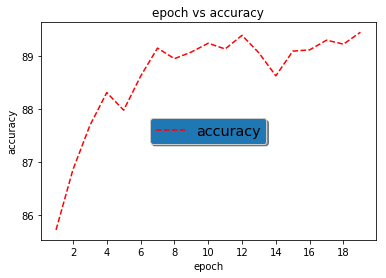

In [0]:

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
epoch = np.arange(20)
epoch = np.delete(epoch, 0)


fig, ax = plt.subplots()
ax.plot(epoch,accuracy,'k--',label="accuracy",color="red")
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))


legend = ax.legend(loc='center',shadow=True, fontsize='x-large')

legend.get_frame().set_facecolor('C0')

plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("epoch vs accuracy")
plt.savefig("data1")
plt.show()

## Plot Model Loss

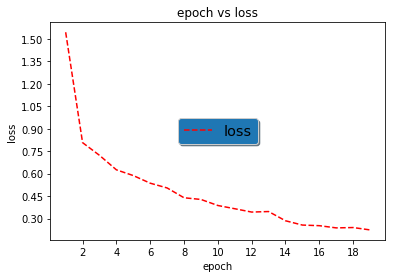

In [0]:
fig, ax = plt.subplots()
ax.plot(epoch,loss,'k--',label="loss",color="red")
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))


legend = ax.legend(loc='center',shadow=True, fontsize='x-large')

legend.get_frame().set_facecolor('C0')

plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("epoch vs loss")
plt.savefig("data2")
plt.show()

# Plot Model loss by Different optimizer

In [0]:
%%time


'''Initialise the proposed neural network'''
nn = MLP([128,256,512,128,10],['relu','relu','relu','relu','softmax'],mini_batch_size=200)

'''Fit data to train the model'''
lossNO, accuracyNO= nn.fit(x_train, y_train, x_test, y_test, learning_rate=0.01, beta=0.9, epochs=19, optimizer=None, dropout=1,weightDecay="False", batchNorm='yes') 



Epoch: 1	| Test Accuracy: 82.09% | Train Accuracy: 83.19% | Loss: 2.1152
Epoch: 2	| Test Accuracy: 85.05% | Train Accuracy: 86.33% | Loss: 1.2051
Epoch: 3	| Test Accuracy: 83.81% | Train Accuracy: 85.49% | Loss: 1.0138
Epoch: 4	| Test Accuracy: 87.28% | Train Accuracy: 89.80% | Loss: 0.8702
Epoch: 5	| Test Accuracy: 86.72% | Train Accuracy: 89.49% | Loss: 0.7671
Epoch: 6	| Test Accuracy: 87.83% | Train Accuracy: 90.38% | Loss: 0.7376
Epoch: 7	| Test Accuracy: 88.15% | Train Accuracy: 91.56% | Loss: 0.6482
Epoch: 8	| Test Accuracy: 88.18% | Train Accuracy: 91.71% | Loss: 0.6245
Epoch: 9	| Test Accuracy: 86.52% | Train Accuracy: 90.54% | Loss: 0.6111
Epoch: 10	| Test Accuracy: 88.70% | Train Accuracy: 92.84% | Loss: 0.5488
Epoch: 11	| Test Accuracy: 88.58% | Train Accuracy: 93.07% | Loss: 0.5290
Epoch: 12	| Test Accuracy: 88.50% | Train Accuracy: 93.09% | Loss: 0.4917
Epoch: 13	| Test Accuracy: 89.09% | Train Accuracy: 93.82% | Loss: 0.4225
Epoch: 14	| Test Accuracy: 87.80% | Train Accur

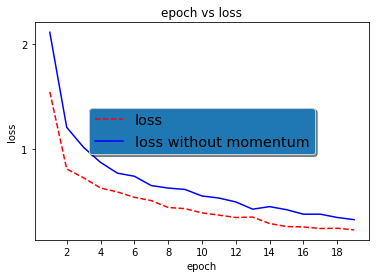

In [0]:
fig, ax = plt.subplots()
ax.plot(epoch,loss,'k--',label="loss",color="red")
ax.plot(epoch,lossNO,'k',label="loss without momentum",color="blue")
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))


legend = ax.legend(loc='center',shadow=True, fontsize='x-large')

legend.get_frame().set_facecolor('C0')

plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("epoch vs loss")
plt.savefig("data3")
plt.show()

#Plot Model Accuracy by Different optimizer

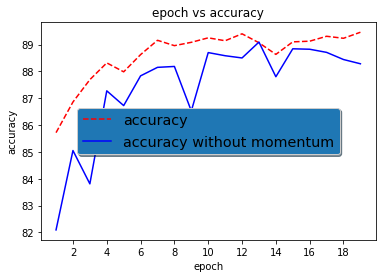

In [0]:
fig, ax = plt.subplots()
ax.plot(epoch,accuracy,'k--',label="accuracy",color="red")
ax.plot(epoch,accuracyNO,'k',label="accuracy without momentum",color="blue")
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))


legend = ax.legend(loc='center',shadow=True, fontsize='x-large')

legend.get_frame().set_facecolor('C0')

plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("epoch vs accuracy")
plt.savefig("data4")
plt.show()


#  Plot Model Accuracy by different dropout

In [0]:
%%time
'''Initialise the proposed neural network'''
nn = MLP([128,256,512,128,10],['relu','relu','relu','relu','softmax'],mini_batch_size=200)

'''Fit data to train the model'''
loss_drop1, accuracy_drop1= nn.fit(x_train, y_train, x_test, y_test, learning_rate=0.01, beta=0.9, epochs=19, optimizer="momentum", dropout=0.9,weightDecay="False", batchNorm='yes') 

Epoch: 1	| Test Accuracy: 85.74% | Train Accuracy: 86.65% | Loss: 1.6193
Epoch: 2	| Test Accuracy: 87.04% | Train Accuracy: 87.98% | Loss: 0.8895
Epoch: 3	| Test Accuracy: 87.78% | Train Accuracy: 89.31% | Loss: 0.8215
Epoch: 4	| Test Accuracy: 87.63% | Train Accuracy: 89.77% | Loss: 0.6969
Epoch: 5	| Test Accuracy: 87.72% | Train Accuracy: 90.27% | Loss: 0.6462
Epoch: 6	| Test Accuracy: 88.64% | Train Accuracy: 90.89% | Loss: 0.6453
Epoch: 7	| Test Accuracy: 88.76% | Train Accuracy: 91.51% | Loss: 0.5862
Epoch: 8	| Test Accuracy: 88.72% | Train Accuracy: 91.88% | Loss: 0.5752
Epoch: 9	| Test Accuracy: 88.98% | Train Accuracy: 92.29% | Loss: 0.5462
Epoch: 10	| Test Accuracy: 88.79% | Train Accuracy: 92.60% | Loss: 0.5158
Epoch: 11	| Test Accuracy: 88.93% | Train Accuracy: 92.70% | Loss: 0.5021
Epoch: 12	| Test Accuracy: 89.31% | Train Accuracy: 93.46% | Loss: 0.5062
Epoch: 13	| Test Accuracy: 89.20% | Train Accuracy: 93.54% | Loss: 0.4316
Epoch: 14	| Test Accuracy: 88.93% | Train Accur

In [0]:
%%time
'''Initialise the proposed neural network'''
nn = MLP([128,256,512,128,10],['relu','relu','relu','relu','softmax'],mini_batch_size=200)

'''Fit data to train the model'''
loss_drop3, accuracy_drop3= nn.fit(x_train, y_train, x_test, y_test, learning_rate=0.01, beta=0.9, epochs=19, optimizer="momentum", dropout=0.6,weightDecay="False", batchNorm='yes') 

Epoch: 1	| Test Accuracy: 82.72% | Train Accuracy: 83.36% | Loss: 2.0872
Epoch: 2	| Test Accuracy: 85.45% | Train Accuracy: 86.16% | Loss: 1.2141
Epoch: 3	| Test Accuracy: 85.64% | Train Accuracy: 87.09% | Loss: 1.0710
Epoch: 4	| Test Accuracy: 86.49% | Train Accuracy: 87.99% | Loss: 0.9790
Epoch: 5	| Test Accuracy: 87.21% | Train Accuracy: 88.48% | Loss: 0.9830
Epoch: 6	| Test Accuracy: 87.49% | Train Accuracy: 88.99% | Loss: 0.9349
Epoch: 7	| Test Accuracy: 87.72% | Train Accuracy: 89.33% | Loss: 0.8585
Epoch: 8	| Test Accuracy: 87.85% | Train Accuracy: 89.59% | Loss: 0.8559
Epoch: 9	| Test Accuracy: 88.24% | Train Accuracy: 89.72% | Loss: 0.8246
Epoch: 10	| Test Accuracy: 87.88% | Train Accuracy: 90.03% | Loss: 0.7898
Epoch: 11	| Test Accuracy: 87.99% | Train Accuracy: 90.21% | Loss: 0.7872
Epoch: 12	| Test Accuracy: 88.10% | Train Accuracy: 90.66% | Loss: 0.7427
Epoch: 13	| Test Accuracy: 88.29% | Train Accuracy: 90.88% | Loss: 0.7748
Epoch: 14	| Test Accuracy: 88.61% | Train Accur

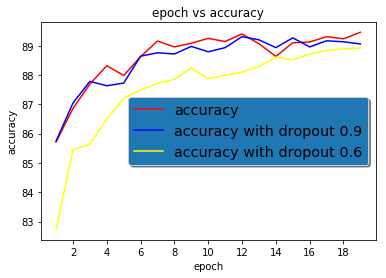

In [0]:
fig, ax = plt.subplots()
ax.plot(epoch,accuracy,'k',label="accuracy",color="red")
ax.plot(epoch,accuracy_drop1,'k',label="accuracy with dropout 0.9",color="blue")
ax.plot(epoch,accuracy_drop3,'k',label="accuracy with dropout 0.6",color="yellow")
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))


legend = ax.legend(loc='center right',shadow=True, fontsize='x-large')

legend.get_frame().set_facecolor('C0')

plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("epoch vs accuracy")
plt.savefig("data5")
plt.show()

#Plot Model loss by different dropout

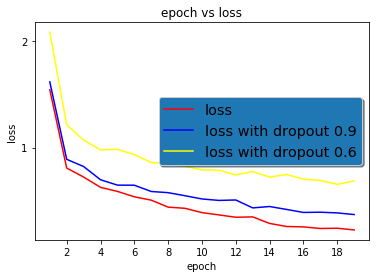

In [0]:
fig, ax = plt.subplots()
ax.plot(epoch,loss,'k',label="loss",color="red")
ax.plot(epoch,loss_drop1,'k',label="loss with dropout 0.9",color="blue")
ax.plot(epoch,loss_drop3,'k',label="loss with dropout 0.6",color="yellow")
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))


legend = ax.legend(loc='center right',shadow=True, fontsize='x-large')

legend.get_frame().set_facecolor('C0')

plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("epoch vs loss")
plt.savefig("data6")
plt.show()

#Plot Model accuracy by different mini batch size

In [0]:
%%time
'''Initialise the proposed neural network'''
nn = MLP([128,256,512,256,10],['relu','relu','relu','relu','softmax'],mini_batch_size=32)

'''Fit data to train the model'''
loss_size32, accuracy_size32= nn.fit(x_train, y_train, x_test, y_test, learning_rate=0.01, beta=0.9, epochs=10, optimizer="momentum", dropout=1,weightDecay="False", batchNorm='yes') 

Epoch: 1	| Test Accuracy: 84.09% | Train Accuracy: 85.75% | Loss: 1.2577
Epoch: 2	| Test Accuracy: 84.88% | Train Accuracy: 86.96% | Loss: 0.9098
Epoch: 3	| Test Accuracy: 85.67% | Train Accuracy: 88.84% | Loss: 0.8349
Epoch: 4	| Test Accuracy: 86.32% | Train Accuracy: 89.22% | Loss: 0.7705
Epoch: 5	| Test Accuracy: 86.63% | Train Accuracy: 89.93% | Loss: 0.7344
Epoch: 6	| Test Accuracy: 87.02% | Train Accuracy: 90.34% | Loss: 0.6868
Epoch: 7	| Test Accuracy: 86.90% | Train Accuracy: 91.07% | Loss: 0.6448
Epoch: 8	| Test Accuracy: 86.83% | Train Accuracy: 91.10% | Loss: 0.6259
Epoch: 9	| Test Accuracy: 86.93% | Train Accuracy: 91.64% | Loss: 0.5995
Epoch: 10	| Test Accuracy: 87.35% | Train Accuracy: 91.80% | Loss: 0.5708
CPU times: user 5min 32s, sys: 2min 27s, total: 7min 59s
Wall time: 4min 1s


In [0]:
%%time
'''Initialise the proposed neural network'''
nn = MLP([128,256,512,256,10],['relu','relu','relu','relu','softmax'],mini_batch_size=200)

'''Fit data to train the model'''
loss_size200, accuracy_size200= nn.fit(x_train, y_train, x_test, y_test, learning_rate=0.01, beta=0.9, epochs=10, optimizer="momentum", dropout=1,weightDecay="False", batchNorm='yes') 

Epoch: 1	| Test Accuracy: 86.30% | Train Accuracy: 87.33% | Loss: 1.5206
Epoch: 2	| Test Accuracy: 86.70% | Train Accuracy: 88.38% | Loss: 0.7901
Epoch: 3	| Test Accuracy: 87.61% | Train Accuracy: 90.13% | Loss: 0.7057
Epoch: 4	| Test Accuracy: 88.01% | Train Accuracy: 90.82% | Loss: 0.6071
Epoch: 5	| Test Accuracy: 88.25% | Train Accuracy: 90.92% | Loss: 0.5677
Epoch: 6	| Test Accuracy: 88.33% | Train Accuracy: 92.30% | Loss: 0.5270
Epoch: 7	| Test Accuracy: 88.56% | Train Accuracy: 92.27% | Loss: 0.4756
Epoch: 8	| Test Accuracy: 88.26% | Train Accuracy: 92.83% | Loss: 0.4653
Epoch: 9	| Test Accuracy: 88.38% | Train Accuracy: 93.09% | Loss: 0.4186
Epoch: 10	| Test Accuracy: 88.69% | Train Accuracy: 94.33% | Loss: 0.4015
CPU times: user 4min 8s, sys: 1min 28s, total: 5min 37s
Wall time: 2min 50s


In [0]:
%%time
'''Initialise the proposed neural network'''
nn = MLP([128,256,512,256,10],['relu','relu','relu','relu','softmax'],mini_batch_size=512)

'''Fit data to train the model'''
loss_size512, accuracy_size512= nn.fit(x_train, y_train, x_test, y_test, learning_rate=0.01, beta=0.9, epochs=10, optimizer="momentum", dropout=1,weightDecay="False", batchNorm='yes') 

Epoch: 1	| Test Accuracy: 79.06% | Train Accuracy: 80.34% | Loss: 7.4769
Epoch: 2	| Test Accuracy: 73.24% | Train Accuracy: 74.75% | Loss: 3.8441
Epoch: 3	| Test Accuracy: 82.27% | Train Accuracy: 84.22% | Loss: 3.7807
Epoch: 4	| Test Accuracy: 82.69% | Train Accuracy: 84.82% | Loss: 4.2644
Epoch: 5	| Test Accuracy: 84.92% | Train Accuracy: 87.05% | Loss: 3.9250
Epoch: 6	| Test Accuracy: 85.42% | Train Accuracy: 88.21% | Loss: 1.6985
Epoch: 7	| Test Accuracy: 86.33% | Train Accuracy: 88.97% | Loss: 1.0593
Epoch: 8	| Test Accuracy: 86.43% | Train Accuracy: 89.42% | Loss: 1.0820
Epoch: 9	| Test Accuracy: 85.14% | Train Accuracy: 88.11% | Loss: 0.9525
Epoch: 10	| Test Accuracy: 85.88% | Train Accuracy: 89.06% | Loss: 0.9629
CPU times: user 3min 48s, sys: 1min 21s, total: 5min 10s
Wall time: 2min 36s


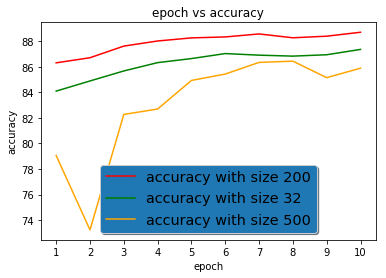

In [0]:
fig, ax = plt.subplots()
epoch = np.arange(11)
epoch = np.delete(epoch, 0)
ax.plot(epoch,accuracy_size200,'k',label="accuracy with size 200",color="red")

ax.plot(epoch,accuracy_size32,'k',label="accuracy with size 32",color="green")

ax.plot(epoch,accuracy_size512,'k',label="accuracy with size 500",color="orange")
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))


legend = ax.legend(loc='lower center',shadow=True, fontsize='x-large')

legend.get_frame().set_facecolor('C0')

plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("epoch vs accuracy")
plt.savefig("data7")
plt.show()

#Plot Model loss by different mini batch size

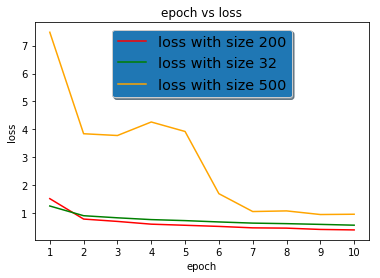

In [0]:
fig, ax = plt.subplots()


ax.plot(epoch,loss_size200,'k',label="loss with size 200",color="red")

ax.plot(epoch,loss_size32,'k',label="loss with size 32",color="green")


ax.plot(epoch,loss_size512,'k',label="loss with size 500",color="orange")
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))


legend = ax.legend(loc='upper center',shadow=True, fontsize='x-large')

legend.get_frame().set_facecolor('C0')

plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("epoch vs loss")
plt.savefig("data8")
plt.show()

# Plot Model Accuracy by using weight decay

In [0]:
%%time
'''Initialise the proposed neural network'''
nn = MLP([128,256,512,128,10],['relu','relu','relu','relu','softmax'],mini_batch_size=200)

'''Fit data to train the model'''
loss_weightDecay, accuracy_weightDecay= nn.fit(x_train, y_train, x_test, y_test, learning_rate=0.01, beta=0.9, epochs=10, optimizer="momentum", dropout=1,weightDecay="True", batchNorm='yes') 

Epoch: 1	| Test Accuracy: 86.05% | Train Accuracy: 87.23% | Loss: 1.4682
Epoch: 2	| Test Accuracy: 87.18% | Train Accuracy: 88.64% | Loss: 0.7739
Epoch: 3	| Test Accuracy: 87.97% | Train Accuracy: 89.76% | Loss: 0.6324
Epoch: 4	| Test Accuracy: 87.92% | Train Accuracy: 90.68% | Loss: 0.5884
Epoch: 5	| Test Accuracy: 88.38% | Train Accuracy: 91.36% | Loss: 0.5541
Epoch: 6	| Test Accuracy: 88.53% | Train Accuracy: 92.10% | Loss: 0.5511
Epoch: 7	| Test Accuracy: 88.83% | Train Accuracy: 92.63% | Loss: 0.4549
Epoch: 8	| Test Accuracy: 88.85% | Train Accuracy: 93.24% | Loss: 0.4628
Epoch: 9	| Test Accuracy: 88.82% | Train Accuracy: 93.59% | Loss: 0.4132
Epoch: 10	| Test Accuracy: 88.71% | Train Accuracy: 93.78% | Loss: 0.3892
CPU times: user 3min 21s, sys: 1min 14s, total: 4min 36s
Wall time: 2min 19s


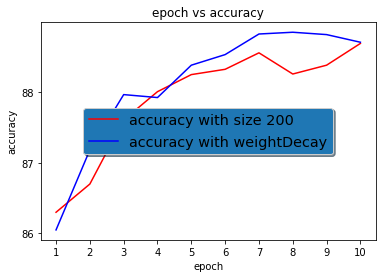

In [0]:
fig, ax = plt.subplots()
ax.plot(epoch,accuracy_size200,'k',label="accuracy with size 200",color="red")
ax.plot(epoch,accuracy_weightDecay,'k',label="accuracy with weightDecay",color="blue")

for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))


legend = ax.legend(loc='center',shadow=True, fontsize='x-large')

legend.get_frame().set_facecolor('C0')

plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("epoch vs accuracy")
plt.savefig("data9")
plt.show()

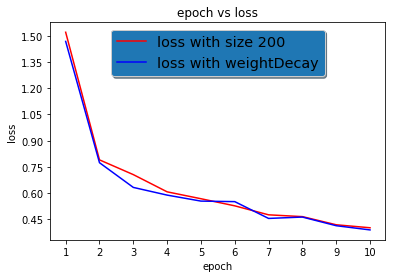

In [0]:
fig, ax = plt.subplots()
ax.plot(epoch,loss_size200,'k',label="loss with size 200",color="red")
ax.plot(epoch,loss_weightDecay,'k',label="loss with weightDecay",color="blue")

for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))


legend = ax.legend(loc='upper center',shadow=True, fontsize='x-large')

legend.get_frame().set_facecolor('C0')

plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("epoch vs loss")
plt.savefig("data10")
plt.show()

#Plot Model time by using Batch Normalization

In [0]:
%%time
'''Initialise the proposed neural network'''
nn = MLP([128,256,512,128,10],['relu','relu','relu','relu','softmax'],mini_batch_size=200)

'''Fit data to train the model'''
loss_nonorm, accuracy_nonorm= nn.fit(x_train, y_train, x_test, y_test, learning_rate=0.01, beta=0.9, epochs=10, optimizer="momentum", dropout=1,weightDecay="False", batchNorm='no') 

Epoch: 1	| Test Accuracy: 85.35% | Train Accuracy: 86.44% | Loss: 1.4505
Epoch: 2	| Test Accuracy: 86.92% | Train Accuracy: 88.48% | Loss: 0.7952
Epoch: 3	| Test Accuracy: 88.02% | Train Accuracy: 89.93% | Loss: 0.7015
Epoch: 4	| Test Accuracy: 88.02% | Train Accuracy: 90.79% | Loss: 0.6165
Epoch: 5	| Test Accuracy: 88.44% | Train Accuracy: 91.34% | Loss: 0.5353
Epoch: 6	| Test Accuracy: 88.15% | Train Accuracy: 91.86% | Loss: 0.5167
Epoch: 7	| Test Accuracy: 88.53% | Train Accuracy: 92.31% | Loss: 0.4806
Epoch: 8	| Test Accuracy: 88.72% | Train Accuracy: 92.87% | Loss: 0.4569
Epoch: 9	| Test Accuracy: 88.73% | Train Accuracy: 93.14% | Loss: 0.4354
Epoch: 10	| Test Accuracy: 88.85% | Train Accuracy: 93.77% | Loss: 0.3859
CPU times: user 3min 27s, sys: 1min 16s, total: 4min 43s
Wall time: 2min 22s


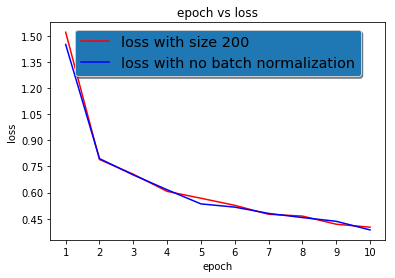

In [0]:
fig, ax = plt.subplots()
ax.plot(epoch,loss_size200,'k',label="loss with size 200",color="red")
ax.plot(epoch,loss_nonorm,'k',label="loss with no batch normalization",color="blue")

for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))


legend = ax.legend(loc='upper center',shadow=True, fontsize='x-large')

legend.get_frame().set_facecolor('C0')

plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("epoch vs loss")
plt.savefig("data11")
plt.show()

# Plot Model Accuracy by using Batch Normalization

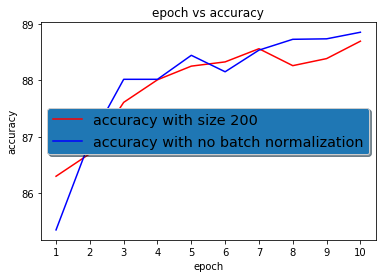

In [0]:
fig, ax = plt.subplots()
ax.plot(epoch,accuracy_size200,'k',label="accuracy with size 200",color="red")
ax.plot(epoch,accuracy_nonorm,'k',label="accuracy with no batch normalization",color="blue")

for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))


legend = ax.legend(loc='center',shadow=True, fontsize='x-large')

legend.get_frame().set_facecolor('C0')

plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("epoch vs accuracy")
plt.savefig("data12")
plt.show()

#  Final Model and Result File

In [0]:
%%time


'''Define training and test data of ratio 9:1'''
# Train
x_train = data[0:60000,:]
y_train = label[0:60000]
# Test
x_test = data[48000:60000,:]
y_test = label[48000:60000]
#accuracy = []
'''Initialise the proposed neural network'''
nn = MLP([128,256,512,128,10],['relu','relu','relu','relu','softmax'],mini_batch_size=200)

'''Fit data to train the model'''
loss, accuracy= nn.fit(x_train, y_train, x_test, y_test, learning_rate=0.01, beta=0.9, epochs=19, optimizer='momentum', dropout=1,weightDecay="False", batchNorm='yes') 



Epoch: 1	| Test Accuracy: 87.08% | Train Accuracy: 87.18% | Loss: 1.3308
Epoch: 2	| Test Accuracy: 89.05% | Train Accuracy: 89.23% | Loss: 0.7836
Epoch: 3	| Test Accuracy: 89.63% | Train Accuracy: 89.72% | Loss: 0.6643
Epoch: 4	| Test Accuracy: 90.61% | Train Accuracy: 90.77% | Loss: 0.5992
Epoch: 5	| Test Accuracy: 91.33% | Train Accuracy: 91.17% | Loss: 0.5527
Epoch: 6	| Test Accuracy: 91.58% | Train Accuracy: 91.51% | Loss: 0.5310
Epoch: 7	| Test Accuracy: 92.48% | Train Accuracy: 92.34% | Loss: 0.4655
Epoch: 8	| Test Accuracy: 92.66% | Train Accuracy: 92.81% | Loss: 0.4475
Epoch: 9	| Test Accuracy: 92.59% | Train Accuracy: 92.92% | Loss: 0.4630
Epoch: 10	| Test Accuracy: 93.57% | Train Accuracy: 93.62% | Loss: 0.4043
Epoch: 11	| Test Accuracy: 93.70% | Train Accuracy: 93.91% | Loss: 0.3674
Epoch: 12	| Test Accuracy: 94.46% | Train Accuracy: 94.37% | Loss: 0.3636
Epoch: 13	| Test Accuracy: 94.25% | Train Accuracy: 94.19% | Loss: 0.3311
Epoch: 14	| Test Accuracy: 94.88% | Train Accur

In [0]:
test_label = nn.predict(test_data)
test_label = np.argmax(test_label,axis=1)
print(test_label)

[9 2 1 ... 8 1 5]


In [0]:
# write to h5 file
with h5py.File('predicted.labels.h5', 'w') as hdf:
  hdf.create_dataset('label', data=test_label)
  
with h5py.File('predicted.labels.h5','r') as H:
     pred = np.copy(H['label'])


In [0]:
with h5py.File('predicted.labels.h5','r') as H: 
  final_test_labels = np.copy(H['label'])
print(final_test_labels)

[9 2 1 ... 8 1 5]
